# 03: Bigram Model

*The simplest autoregressive language model.*

---

Notebooks 01-02 taught us that bag-of-words is a dead end. Averaging destroys position information, so adding positional encoding did nothing. You can't turn a brownie into a cake.

Now we start fresh with the right foundation: **autoregressive language modeling.**

**The idea:** To predict token N, look at token N-1. That's it. No averaging, no looking at the whole sequence—just "given the previous token, what comes next?"

**The architecture:**
```
Previous token → Embedding → Unembed → Next token prediction
```

This is a **bigram model**—it learns the probability of token B given token A. P("girl" | "the"), P("upon" | "once"), etc.

**What we expect:** It'll learn common word pairs. "once" → "upon", "upon" → "a", "a" → "time". But it has no memory beyond one token—it can't learn "once upon a time" as a unit, just adjacent pairs.

**Why this matters:** This is the embryo of a real language model. We'll add context (attention) and depth (layers) from here.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
import math

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


---

## 1. Load Data and Tokenizer

Same data, but we'll use it differently. Instead of predicting one token from the whole sequence, we'll predict *every* token from its predecessor.

In [2]:
from transformers import GPT2TokenizerFast

class LilTokenizer:
    """Compact tokenizer for Lil Transformy (copied from notebook 00)."""
    
    def __init__(self, gpt2_to_compact, compact_to_gpt2, vocab_size):
        self.gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        self.gpt2_to_compact = gpt2_to_compact
        self.compact_to_gpt2 = compact_to_gpt2
        self.vocab_size = vocab_size
        self.pad_id = 0
        self.unk_id = 1
        self.eos_id = 2
    
    def encode(self, text, add_eos=True):
        gpt2_tokens = self.gpt2_tokenizer.encode(text)
        compact_tokens = [self.gpt2_to_compact.get(t, self.unk_id) for t in gpt2_tokens]
        if add_eos:
            compact_tokens.append(self.eos_id)
        return compact_tokens
    
    def decode(self, token_ids):
        gpt2_tokens = []
        for tid in token_ids:
            if tid in [self.pad_id, self.unk_id, self.eos_id]:
                continue
            if tid in self.compact_to_gpt2:
                gpt2_tokens.append(self.compact_to_gpt2[tid])
        return self.gpt2_tokenizer.decode(gpt2_tokens)
    
    def decode_single(self, token_id):
        """Decode a single token ID to its string representation."""
        if token_id == self.pad_id:
            return '<pad>'
        if token_id == self.unk_id:
            return '<unk>'
        if token_id == self.eos_id:
            return '<eos>'
        if token_id in self.compact_to_gpt2:
            return self.gpt2_tokenizer.decode([self.compact_to_gpt2[token_id]])
        return '<???>'  
    
    def __len__(self):
        return self.vocab_size
    
    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            config = json.load(f)
        gpt2_to_compact = {int(k): v for k, v in config['gpt2_to_compact'].items()}
        compact_to_gpt2 = {int(k): v for k, v in config['compact_to_gpt2'].items()}
        return cls(gpt2_to_compact, compact_to_gpt2, config['vocab_size'])


# Load tokenizer
tokenizer = LilTokenizer.load('tokenizer/tokenizer.json')
print(f"Vocabulary size: {len(tokenizer):,}")

Vocabulary size: 4,096


In [3]:
# Load pre-tokenized sequences
train_data = np.load('data/train_sequences.npy')
val_data = np.load('data/val_sequences.npy')

print(f"Training sequences: {train_data.shape}")
print(f"Validation sequences: {val_data.shape}")
print(f"Context length: {train_data.shape[1]}")

Training sequences: (1851532, 256)
Validation sequences: (18616, 256)
Context length: 256


---

## 2. Model Architecture

### The Bigram Model

The simplest autoregressive model:
- Input: token at position t
- Output: probability distribution over token at position t+1

That's it. Each token only looks at its immediate predecessor.

### How Training Works Now

**Before (bag-of-words):** One prediction per sequence
- Input: all 255 tokens
- Target: 1 token (the last one)
- Training signal: 1 gradient per sequence

**Now (autoregressive):** Many predictions per sequence
- Input: tokens [0, 1, 2, ..., 254]
- Targets: tokens [1, 2, 3, ..., 255]
- Training signal: 255 gradients per sequence!

This is why autoregressive models are so data-efficient—every position is a training example.

In [4]:
class BigramLM(nn.Module):
    """
    The simplest autoregressive language model.
    
    Architecture:
        Input token → Embedding → Linear → Next token prediction
    
    Each token independently predicts the next token.
    No context beyond the immediate predecessor.
    """
    
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        
        # Token embedding: token ID → vector
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # Output projection: vector → logits over vocabulary
        self.unembed = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        """
        Args:
            x: Input token IDs, shape [batch, seq_len]
        
        Returns:
            logits: Shape [batch, seq_len, vocab_size]
                    Each position predicts the NEXT token.
        """
        # Embed each token: [batch, seq_len] → [batch, seq_len, d_model]
        embedded = self.embedding(x)
        
        # Project each position to vocabulary: [batch, seq_len, d_model] → [batch, seq_len, vocab_size]
        logits = self.unembed(embedded)
        
        return logits
    
    def generate(self, prompt_tokens, max_new_tokens=50):
        """
        Generate tokens autoregressively.
        
        Args:
            prompt_tokens: List of token IDs to start from
            max_new_tokens: How many tokens to generate
        
        Returns:
            List of generated token IDs (not including prompt)
        """
        self.eval()
        tokens = list(prompt_tokens)
        generated = []
        
        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Only need the last token for bigram model
                last_token = torch.tensor([[tokens[-1]]], device=next(self.parameters()).device)
                
                # Get prediction for next token
                logits = self.forward(last_token)  # [1, 1, vocab_size]
                probs = F.softmax(logits[0, 0], dim=-1)  # [vocab_size]
                
                # Sample from distribution
                next_token = torch.multinomial(probs, num_samples=1).item()
                
                generated.append(next_token)
                tokens.append(next_token)
                
                # Stop at EOS
                if next_token == 2:  # EOS
                    break
        
        return generated

In [5]:
# === Model Parameters ===
VOCAB_SIZE = len(tokenizer)  # 4096
D_MODEL = 128                # Embedding dimension

# Create model
model = BigramLM(VOCAB_SIZE, D_MODEL).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {num_params:,}")
print(f"  Embedding: {VOCAB_SIZE} × {D_MODEL} = {VOCAB_SIZE * D_MODEL:,}")
print(f"  Unembed:   {D_MODEL} × {VOCAB_SIZE} + {VOCAB_SIZE} = {D_MODEL * VOCAB_SIZE + VOCAB_SIZE:,}")
print(f"")
print(f"Same parameter count as notebook 01! But used very differently.")

Model parameters: 1,052,672
  Embedding: 4096 × 128 = 524,288
  Unembed:   128 × 4096 + 4096 = 528,384

Same parameter count as notebook 01! But used very differently.


---

## 3. Training Setup

The key change: **every position is a training example.**

- Input: tokens [0, 1, 2, ..., 254] 
- Targets: tokens [1, 2, 3, ..., 255]

Position 0 predicts position 1. Position 1 predicts position 2. And so on.

We get 255 predictions per sequence instead of 1. That's 255× more training signal!

In [6]:
# === Training Parameters ===
BATCH_SIZE = 64   # Smaller batches since each gives 255× more gradients
LEARNING_RATE = 1e-3
NUM_EPOCHS = 1    # Bigram statistics are simple—one epoch is enough
EVAL_EVERY = 500  # More frequent eval since we're learning faster

def make_batch(data, batch_indices):
    """
    Create a training batch for autoregressive training.
    
    Input:  tokens [0, 1, 2, ..., 254]  (all but last)
    Target: tokens [1, 2, 3, ..., 255]  (all but first)
    
    Each input position predicts the next position.
    """
    sequences = data[batch_indices]  # [batch, 256]
    
    # Input: all tokens except the last
    x = torch.tensor(sequences[:, :-1], dtype=torch.long, device=device)  # [batch, 255]
    
    # Target: all tokens except the first (shifted by 1)
    y = torch.tensor(sequences[:, 1:], dtype=torch.long, device=device)   # [batch, 255]
    
    return x, y


# Test batch creation
test_x, test_y = make_batch(train_data, np.arange(4))
print(f"Input shape:  {test_x.shape}")   # [4, 255]
print(f"Target shape: {test_y.shape}")   # [4, 255]
print(f"")
print(f"For sequence 0:")
print(f"  Input[0]:  {test_x[0, :5].tolist()}...")
print(f"  Target[0]: {test_y[0, :5].tolist()}...")
print(f"  (Target is input shifted by 1)")

Input shape:  torch.Size([4, 255])
Target shape: torch.Size([4, 255])

For sequence 0:
  Input[0]:  [107, 23, 6, 9, 40]...
  Target[0]: [23, 6, 9, 40, 63]...
  (Target is input shifted by 1)


In [7]:
# Optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Calculate total steps
steps_per_epoch = len(train_data) // BATCH_SIZE
total_steps = steps_per_epoch * NUM_EPOCHS

print(f"Steps per epoch: {steps_per_epoch:,}")
print(f"Total steps: {total_steps:,}")
print(f"")
print(f"Training examples per step: {BATCH_SIZE} sequences × 255 positions = {BATCH_SIZE * 255:,}")

Steps per epoch: 28,930
Total steps: 28,930

Training examples per step: 64 sequences × 255 positions = 16,320


In [8]:
def evaluate(model, data, num_batches=50):
    """
    Evaluate model on validation data.
    
    Loss is averaged over all positions in all sequences.
    """
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    indices = np.random.choice(len(data), size=num_batches * BATCH_SIZE, replace=False)
    
    with torch.no_grad():
        for i in range(num_batches):
            batch_idx = indices[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
            x, y = make_batch(data, batch_idx)
            
            # Forward pass: [batch, seq_len] → [batch, seq_len, vocab_size]
            logits = model(x)
            
            # Reshape for cross-entropy: need [N, vocab_size] and [N]
            # Flatten batch and sequence dimensions
            logits_flat = logits.view(-1, VOCAB_SIZE)  # [batch * seq_len, vocab_size]
            y_flat = y.view(-1)                         # [batch * seq_len]
            
            loss = criterion(logits_flat, y_flat)
            
            total_loss += loss.item() * y_flat.numel()
            total_tokens += y_flat.numel()
    
    model.train()
    avg_loss = total_loss / total_tokens
    return {
        'loss': avg_loss,
        'perplexity': math.exp(avg_loss)
    }

---

## 4. Training Loop

In [9]:
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_perplexity': []
}

print("Starting training...")
print("=" * 60)

step = 0
running_loss = 0

for epoch in range(NUM_EPOCHS):
    perm = np.random.permutation(len(train_data))
    epoch_pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    for batch_num in epoch_pbar:
        batch_idx = perm[batch_num * BATCH_SIZE:(batch_num + 1) * BATCH_SIZE]
        x, y = make_batch(train_data, batch_idx)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(x)  # [batch, seq_len, vocab_size]
        
        # Reshape for cross-entropy
        logits_flat = logits.view(-1, VOCAB_SIZE)
        y_flat = y.view(-1)
        
        loss = criterion(logits_flat, y_flat)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        step += 1
        
        if step % EVAL_EVERY == 0:
            avg_train_loss = running_loss / EVAL_EVERY
            val_metrics = evaluate(model, val_data)
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(val_metrics['loss'])
            history['val_perplexity'].append(val_metrics['perplexity'])
            
            epoch_pbar.set_postfix({
                'loss': f"{avg_train_loss:.3f}",
                'val_loss': f"{val_metrics['loss']:.3f}",
                'ppl': f"{val_metrics['perplexity']:.1f}"
            })
            
            running_loss = 0

print("\nTraining complete!")

Starting training...


Epoch 1/1:   0%|          | 0/28930 [00:00<?, ?it/s]


Training complete!


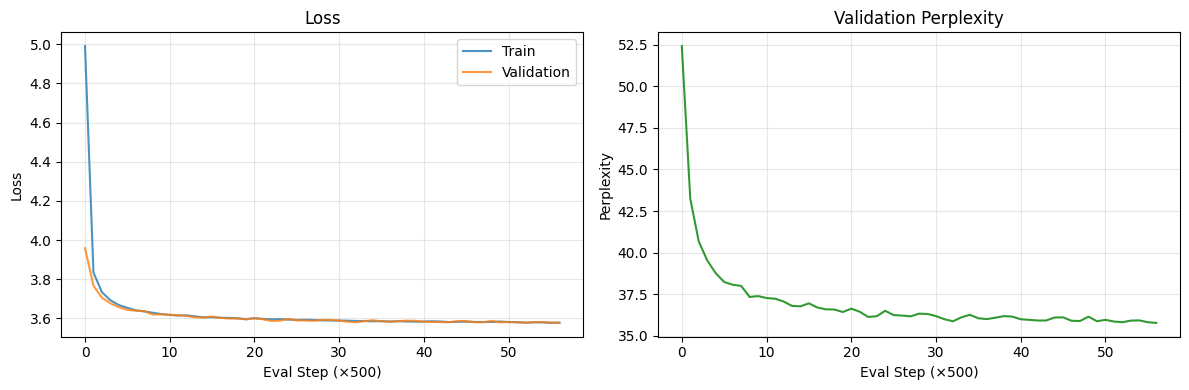


Final validation loss: 3.577
Final validation perplexity: 35.8


In [10]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train', alpha=0.8)
axes[0].plot(history['val_loss'], label='Validation', alpha=0.8)
axes[0].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Perplexity
axes[1].plot(history['val_perplexity'], color='green', alpha=0.8)
axes[1].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Validation Perplexity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('03_training_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nFinal validation loss: {history['val_loss'][-1]:.3f}")
print(f"Final validation perplexity: {history['val_perplexity'][-1]:.1f}")

---

## 5. Comparison with Previous Models

How does the bigram model compare to the bag-of-words models?

**Important note:** The comparison isn't quite apples-to-apples:
- Notebooks 01-02: Predicted one token (the last) from all previous tokens
- Notebook 03: Predicts every token from just the previous token

But perplexity is still comparable—it measures "how surprised is the model by the correct answer?"

In [11]:
# Load previous results
checkpoint_01 = torch.load('01_bag_of_words.pt', map_location='cpu', weights_only=False)
checkpoint_02 = torch.load('02_positional.pt', map_location='cpu', weights_only=False)

print("=" * 60)
print("COMPARISON: Bag-of-Words vs Bigram")
print("=" * 60)
print(f"")
print(f"{'Model':<25} {'Final Val Loss':<15} {'Final Val PPL':<15}")
print(f"-" * 55)
print(f"{'01: Bag of Words':<25} {checkpoint_01['history']['val_loss'][-1]:<15.3f} {checkpoint_01['history']['val_perplexity'][-1]:<15.1f}")
print(f"{'02: + Positional':<25} {checkpoint_02['history']['val_loss'][-1]:<15.3f} {checkpoint_02['history']['val_perplexity'][-1]:<15.1f}")
print(f"{'03: Bigram':<25} {history['val_loss'][-1]:<15.3f} {history['val_perplexity'][-1]:<15.1f}")
print(f"")
print(f"Note: Lower is better for both metrics.")

COMPARISON: Bag-of-Words vs Bigram

Model                     Final Val Loss  Final Val PPL  
-------------------------------------------------------
01: Bag of Words          5.601           270.8          
02: + Positional          5.603           271.3          
03: Bigram                3.577           35.8           

Note: Lower is better for both metrics.


---

## 6. Generation: The Moment of Truth

Let's see how the bigram model generates text. Remember: it can only look at the previous token, so it's essentially doing a random walk through bigram probabilities.

In [12]:
def generate_and_print(prompt, max_tokens=50):
    """Generate from a prompt and print results."""
    prompt_tokens = tokenizer.encode(prompt, add_eos=False)
    generated_tokens = model.generate(prompt_tokens, max_new_tokens=max_tokens)
    generated_text = tokenizer.decode(generated_tokens)
    
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated_text}")
    print()
    
    return generated_tokens


print("=" * 60)
print("GENERATION TEST")
print("=" * 60)
print()

# The classic test
_ = generate_and_print("Once upon a time")

GENERATION TEST

Prompt: Once upon a time
Generated:  the park to Sam.

They use the boat with fine smile and be patient. So they are happy and suddenly, and Lucy and agreed. She picks up with chocolate. The neighbor was a plan. He was safe. It had done



In [13]:
# More tests
test_prompts = [
    "The little girl",
    "He was very",
    "She went to the",
    "Once upon a time there was a girl named",
]

print("More generations:")
print("-" * 60)
for prompt in test_prompts:
    _ = generate_and_print(prompt, max_tokens=30)

More generations:
------------------------------------------------------------
Prompt: The little girl
Generated:  himself to the wind blew the sand was a purple ice cream together. He said, but the shop and stopped it is angry. You can buy him

Prompt: He was very
Generated:  hard work. From that?"
One day, she felt sad and every day the top of scissors or a very happy because she got a princess Her

Prompt: She went to the
Generated:  teddy's table and continued playing in the muddy and pulled it was proud of the cupboard and nature. She went. One day, this for

Prompt: Once upon a time there was a girl named
Generated:  Lily and said, but still very empty book and stories with her face lit up, "I know the war to take it. It is a feeling



In [14]:
def show_top_predictions(token_str, k=10):
    """
    Show what the model predicts after a given token.
    
    This is the bigram distribution: P(next | token)
    """
    # Encode the token
    tokens = tokenizer.encode(token_str, add_eos=False)
    if not tokens:
        print(f"Could not encode: {token_str}")
        return
    
    last_token = tokens[-1]
    x = torch.tensor([[last_token]], device=device)
    
    with torch.no_grad():
        logits = model(x)  # [1, 1, vocab_size]
        probs = F.softmax(logits[0, 0], dim=-1)
    
    top_probs, top_indices = probs.topk(k)
    
    print(f"After '{token_str}' (token {last_token}), top predictions:")
    for prob, idx in zip(top_probs, top_indices):
        next_token_str = tokenizer.decode_single(idx.item())
        print(f"  {prob.item():.3f}: {repr(next_token_str)}")
    print()


print("=" * 60)
print("BIGRAM DISTRIBUTIONS")
print("=" * 60)
print()

# What comes after common words?
show_top_predictions("Once")
show_top_predictions(" the")
show_top_predictions(" named")
show_top_predictions(" happy")

BIGRAM DISTRIBUTIONS

After 'Once' (token 58), top predictions:
  0.886: ' upon'
  0.101: ' there'
  0.006: ','
  0.001: ' the'
  0.001: ' they'
  0.001: ' he'
  0.001: ' she'
  0.000: ' in'
  0.000: ' inside'
  0.000: ' it'

After ' the' (token 7), top predictions:
  0.037: ' park'
  0.021: '<unk>'
  0.016: ' sky'
  0.015: ' little'
  0.013: ' bird'
  0.013: ' garden'
  0.011: ' sun'
  0.010: ' tree'
  0.010: ' ground'
  0.009: ' car'

After ' named' (token 80), top predictions:
  0.334: ' Lily'
  0.172: ' Tim'
  0.045: '<unk>'
  0.038: ' Max'
  0.029: ' Lucy'
  0.026: ' Jack'
  0.025: ' Tom'
  0.018: ' Sue'
  0.015: ' Benny'
  0.014: ' Bob'

After ' happy' (token 42), top predictions:
  0.264: '.'
  0.232: ' and'
  0.148: ' to'
  0.101: ' that'
  0.029: ','
  0.024: '!'
  0.022: ' again'
  0.021: ' with'
  0.014: ' too'
  0.012: ' because'



---

## 7. Visualizing the Bigram Matrix

The bigram model is essentially learning a big transition matrix: P(token_j | token_i).

Let's visualize part of it.

Visualizing 20 tokens


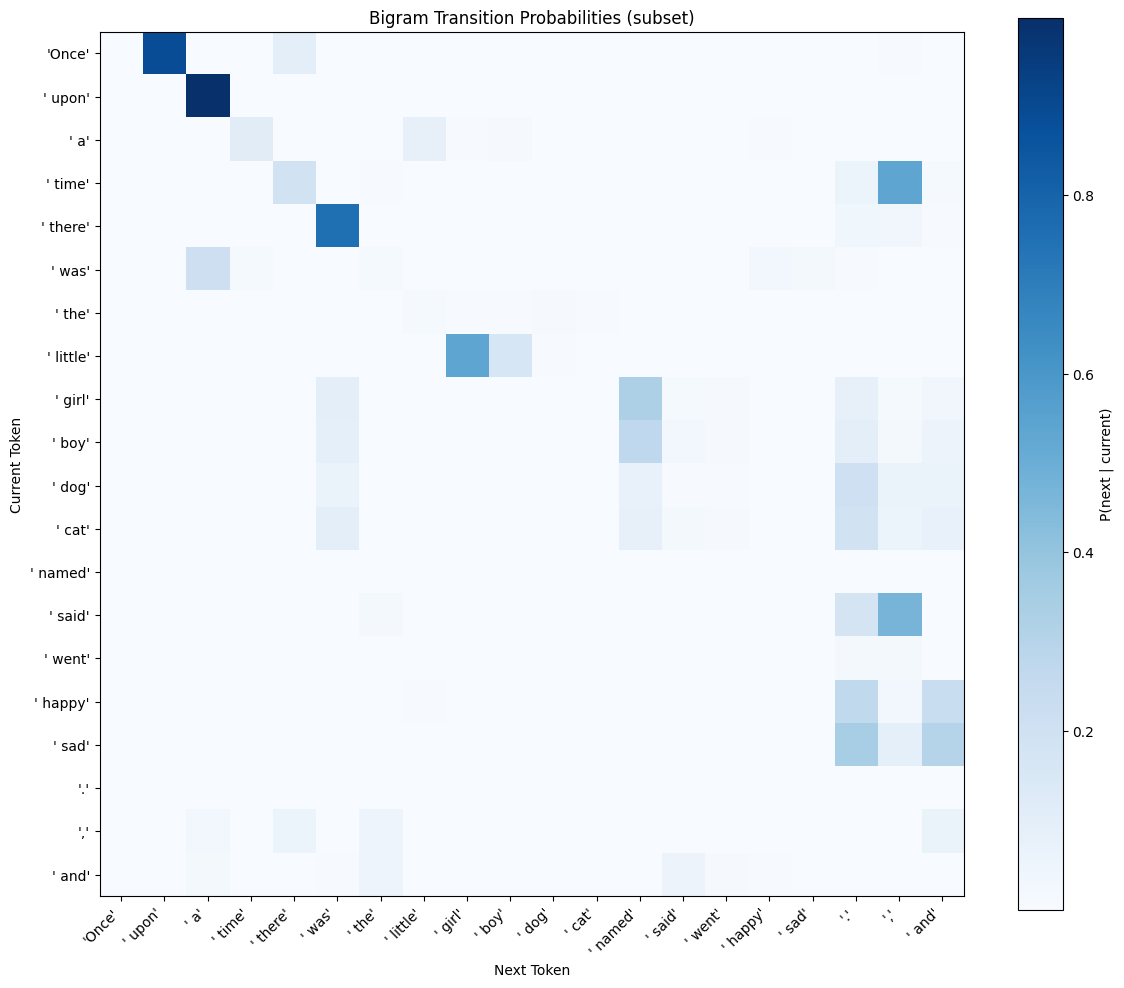

In [15]:
# Compute the effective bigram matrix for a subset of tokens
# Pick some interesting tokens to visualize

interesting_tokens = [
    "Once", " upon", " a", " time", " there", " was",
    " the", " little", " girl", " boy", " dog", " cat",
    " named", " said", " went", " happy", " sad",
    ".", ",", " and"
]

# Get token IDs
token_ids = []
token_labels = []
for t in interesting_tokens:
    encoded = tokenizer.encode(t, add_eos=False)
    if encoded:
        token_ids.append(encoded[-1])  # Last token in case of multi-token
        token_labels.append(t)

n_tokens = len(token_ids)
print(f"Visualizing {n_tokens} tokens")

# Compute transition probabilities
with torch.no_grad():
    x = torch.tensor([token_ids], device=device)  # [1, n_tokens]
    logits = model(x)  # [1, n_tokens, vocab_size]
    probs = F.softmax(logits[0], dim=-1)  # [n_tokens, vocab_size]

# Extract just the transitions between our interesting tokens
transition_matrix = np.zeros((n_tokens, n_tokens))
for i, from_id in enumerate(token_ids):
    for j, to_id in enumerate(token_ids):
        transition_matrix[i, j] = probs[i, to_id].item()

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(transition_matrix, cmap='Blues')

# Labels
ax.set_xticks(range(n_tokens))
ax.set_yticks(range(n_tokens))
ax.set_xticklabels([repr(t) for t in token_labels], rotation=45, ha='right')
ax.set_yticklabels([repr(t) for t in token_labels])

ax.set_xlabel('Next Token')
ax.set_ylabel('Current Token')
ax.set_title('Bigram Transition Probabilities (subset)')

plt.colorbar(im, ax=ax, label='P(next | current)')
plt.tight_layout()
plt.savefig('03_bigram_matrix.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---

## Summary

### What the Bigram Model Learned:
- Common word transitions: "once" → "upon", "the" → "little"/"girl"/"dog"
- Basic TinyStories patterns
- Punctuation patterns: "." often followed by capital letters or newlines

### What It Can't Do:
- Remember beyond one token ("once upon a" → no idea "time" should come next)
- Maintain coherent topics
- Use position information (doesn't know if it's at the start or middle of a sentence)

### Why This Architecture Matters:
This is the **foundation** we'll build on:
- It's autoregressive (predicts next from previous)
- Every position produces a prediction
- The output has shape [batch, seq_len, vocab_size]

All future models will have this same basic structure. We'll just add more sophisticated ways to compute the logits.

### The Lesson:
**One token of context isn't enough. The model needs to see more history.**

In notebook 04, we add positional embeddings—now the model knows *where* in the sequence it is. In notebook 05, we add attention—tokens can finally look at each other.

In [16]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab_size': VOCAB_SIZE,
    'd_model': D_MODEL,
    'history': history,
}

torch.save(checkpoint, '03_bigram.pt')
print("Model saved to 03_bigram.pt")

Model saved to 03_bigram.pt


In [17]:
print("=" * 60)
print("NOTEBOOK 03 COMPLETE")
print("=" * 60)
print(f"\nArchitecture: Token Embed → Unembed (per position)")
print(f"Parameters: {num_params:,}")
print(f"Final perplexity: {history['val_perplexity'][-1]:.1f}")
print(f"")
print(f"The embryo is alive. It knows bigram statistics.")
print(f"But it has no memory beyond one token.")
print(f"Next: Give it position awareness, then attention.")

NOTEBOOK 03 COMPLETE

Architecture: Token Embed → Unembed (per position)
Parameters: 1,052,672
Final perplexity: 35.8

The embryo is alive. It knows bigram statistics.
But it has no memory beyond one token.
Next: Give it position awareness, then attention.
